In [1]:
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')

from formulations.nda import NDA
from formulations.saaf import SAAF
from formulations.diffusion import Diffusion
from fe import *
from materials import Materials
from problem import Problem
from plot import plot, plot_1d
from solvers import Solver

## Setup Problem

In [2]:
mesh = 'symmetric-8'
mat = 'scattering1g'

In [3]:
nodefile = "../test/test_inputs/" + mesh + ".node"
elefile = "../test/test_inputs/" + mesh + ".ele"
matfile = "../test/test_inputs/" + mat + ".mat"
grid = FEGrid(nodefile, elefile)
mats = Materials(matfile)
num_elts = grid.num_elts
num_groups = mats.get_num_groups()
source = np.ones((num_groups, num_elts))

### Diffusion

In [4]:
op = Diffusion(grid, mats)
solver = Solver(op)

In [5]:
diffusion_phis = solver.solve(source)

Within-Group Iteration:  0
Norm:  0.9704290004858718
Within-Group Iteration:  1
Norm:  0.0
Number of Within-Group Iterations:  2
Final Phi Norm:  0.0
Runtime: 1.73091 seconds


### NDA

In [7]:
op = NDA(grid, mats)
solver = Solver(op)

In [8]:
nda_phis = solver.solve(source)

Within-Group Iteration:  0
Norm:  0.43653928374848294
Within-Group Iteration:  1
Norm:  0.002648101245230211
Within-Group Iteration:  2
Norm:  2.8742785265711834e-05
Within-Group Iteration:  3
Norm:  2.7231910924852e-07
Number of Within-Group Iterations:  4
Final Phi Norm:  2.7231910924852e-07
Runtime: 24.71089 seconds


### SAAF

In [9]:
op = SAAF(grid, mats)
solver = Solver(op)

In [10]:
saaf_phis = solver.solve(source)

Within-Group Iteration:  0
Norm:  0.7163467896811728
Within-Group Iteration:  1
Norm:  0.2232382180369143
Within-Group Iteration:  2
Norm:  0.12829899080791207
Within-Group Iteration:  3
Norm:  0.08493741259414345
Within-Group Iteration:  4
Norm:  0.05880369102334193
Within-Group Iteration:  5
Norm:  0.04348789618242643
Within-Group Iteration:  6
Norm:  0.03270152280018224
Within-Group Iteration:  7
Norm:  0.024945012996031024
Within-Group Iteration:  8
Norm:  0.01957810900484791
Within-Group Iteration:  9
Norm:  0.015570586513617979
Within-Group Iteration:  10
Norm:  0.01235680877682388
Within-Group Iteration:  11
Norm:  0.009737550704243647
Within-Group Iteration:  12
Norm:  0.0076279297527461765
Within-Group Iteration:  13
Norm:  0.005945693309251876
Within-Group Iteration:  14
Norm:  0.004615345158309303
Within-Group Iteration:  15
Norm:  0.003570434035024217
Within-Group Iteration:  16
Norm:  0.0027542944537974345
Within-Group Iteration:  17
Norm:  0.0021197520025618144
Within-Gro

### Fix y to plot 1d solution

In [11]:
y = 0.5

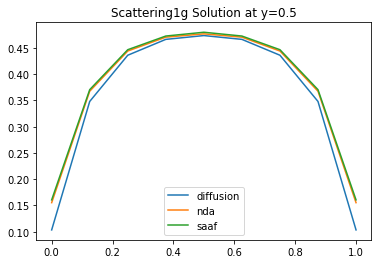

In [12]:
diff_points = plot_1d(grid, diffusion_phis[0], y)
nda_points = plot_1d(grid, nda_phis[0], y)
saaf_points = plot_1d(grid, saaf_phis[0][0], y)
plt.plot(diff_points[:, 0], diff_points[:, 1], label='diffusion')
plt.plot(nda_points[:, 0], nda_points[:, 1], label='nda')
plt.plot(saaf_points[:, 0], saaf_points[:, 1], label='saaf')
plt.legend()
plt.title("Scattering1g Solution at y=0.5")
plt.show()

# Compare Coarser Mesh to Fine Mesh

In [ ]:
mesh = 'symmetric-10'
mat = 'noscatter'

In [ ]:
nodefile = "../test/test_inputs/" + mesh + ".node"
elefile = "../test/test_inputs/" + mesh + ".ele"
matfile = "../test/test_inputs/" + mat + ".mat"
grid = FEGrid(nodefile, elefile)
mats = Materials(matfile)
num_elts = grid.get_num_elts()
num_groups = mats.get_num_groups()
source = np.ones((num_groups, num_elts))

### NDA

In [ ]:
op = NDA(grid, mats)
solver = Solver(op)

In [ ]:
nda_phis = solver.solve(source)

### SAAF

In [ ]:
op = SAAF(grid, mats)
solver = Solver(op)

In [ ]:
saaf_phis = solver.solve(source)

### Calculate Absorption Rate

In [ ]:
def calculate_absorption(grid, mats, phi, group_id):
    triang = grid.setup_triangulation()
    integral = 0
    for elt in range(grid.num_elts):
        midx = grid.get_mat_id(elt)
        sig_a = mats.get_siga(midx, group_id)
        g_nodes = grid.gauss_nodes(elt)
        phi_vals = grid.phi_at_gauss_nodes(triang, phi, g_nodes)
        integral += grid.gauss_quad(elt, sig_a*phi_vals[0])
    return integral

In [ ]:
nda_abs = calculate_absorption(grid, mats, nda_phis, 0)
nda_abs

In [ ]:
saaf_abs = calculate_absorption(grid, mats, saaf_phis[0], 0)
saaf_abs

## Compare SAAF & NDA as Mesh refines

In [14]:
x = np.arange(4, 9)
err = []
for mesh in x:
    # Choose Input
    mesh = 'symmetric-%s' % (str(mesh))
    mat = 'scattering1g'

    # Setup Problem
    nodefile = "../test/test_inputs/" + mesh + ".node"
    elefile = "../test/test_inputs/" + mesh + ".ele"
    matfile = "../test/test_inputs/" + mat + ".mat"
    grid = FEGrid(nodefile, elefile)
    mats = Materials(matfile)
    num_elts = grid.num_elts
    num_groups = mats.get_num_groups()
    source = np.ones((num_groups, num_elts))

    # Solve NDA
    op = NDA(grid, mats)
    solver = Solver(op)
    nda_phis = solver.solve(source)

    # Solve SAAF
    op = SAAF(grid, mats)
    solver = Solver(op)
    saaf_phis = solver.solve(source)

    # Compute Difference
    err.append(np.max(np.abs(nda_phis[0] - saaf_phis[0][0])))
err = np.array(err)
err

Within-Group Iteration:  0
Norm:  0.4164516296365842
Within-Group Iteration:  1
Norm:  0.001053997972770948
Within-Group Iteration:  2
Norm:  2.7331640488764686e-06
Within-Group Iteration:  3
Norm:  8.507161600168622e-09
Number of Within-Group Iterations:  4
Final Phi Norm:  8.507161600168622e-09
Runtime: 1.83307 seconds
Within-Group Iteration:  0
Norm:  0.49923764501781853
Within-Group Iteration:  1
Norm:  0.21389259320833498
Within-Group Iteration:  2
Norm:  0.10678703173595816
Within-Group Iteration:  3
Norm:  0.08702305798917442
Within-Group Iteration:  4
Norm:  0.06564569784952712
Within-Group Iteration:  5
Norm:  0.04818898732702537
Within-Group Iteration:  6
Norm:  0.03716673153314065
Within-Group Iteration:  7
Norm:  0.031036627834416963
Within-Group Iteration:  8
Norm:  0.025285796456547605
Within-Group Iteration:  9
Norm:  0.020240505267114406
Within-Group Iteration:  10
Norm:  0.015994735798944615
Within-Group Iteration:  11
Norm:  0.012519362842499104
Within-Group Iteration

Norm:  5.036723377754848e-05
Within-Group Iteration:  32
Norm:  3.831072954713077e-05
Within-Group Iteration:  33
Norm:  2.9137906732201735e-05
Within-Group Iteration:  34
Norm:  2.2159934849941276e-05
Within-Group Iteration:  35
Norm:  1.6852182357418588e-05
Within-Group Iteration:  36
Norm:  1.2815208472516382e-05
Within-Group Iteration:  37
Norm:  9.74497082928405e-06
Within-Group Iteration:  38
Norm:  7.410091534876262e-06
Within-Group Iteration:  39
Norm:  5.634521514308322e-06
Within-Group Iteration:  40
Norm:  4.284328772086177e-06
Within-Group Iteration:  41
Norm:  3.257634132558529e-06
Within-Group Iteration:  42
Norm:  2.47694744287541e-06
Within-Group Iteration:  43
Norm:  1.883333429708589e-06
Within-Group Iteration:  44
Norm:  1.4319714565225183e-06
Within-Group Iteration:  45
Norm:  1.0887768098766237e-06
Within-Group Iteration:  46
Norm:  8.27830128946605e-07
Number of Within-Group Iterations:  47
Final Phi Norm:  8.27830128946605e-07
Runtime: 41.9176 seconds
Within-Grou

Norm:  0.00586586190686722
Within-Group Iteration:  14
Norm:  0.004553996128683846
Within-Group Iteration:  15
Norm:  0.00352394636590897
Within-Group Iteration:  16
Norm:  0.0027194153153139444
Within-Group Iteration:  17
Norm:  0.002093764936942355
Within-Group Iteration:  18
Norm:  0.0016089804788420592
Within-Group Iteration:  19
Norm:  0.0012344717525816784
Within-Group Iteration:  20
Norm:  0.0009458739283309536
Within-Group Iteration:  21
Norm:  0.0007239393479376854
Within-Group Iteration:  22
Norm:  0.0005535631743256442
Within-Group Iteration:  23
Norm:  0.00042295519070778553
Within-Group Iteration:  24
Norm:  0.0003229526270653871
Within-Group Iteration:  25
Norm:  0.0002464600989020016
Within-Group Iteration:  26
Norm:  0.00018799929606411192
Within-Group Iteration:  27
Norm:  0.00014335069675630585
Within-Group Iteration:  28
Norm:  0.00010927084276324273
Within-Group Iteration:  29
Norm:  8.327069916613805e-05
Within-Group Iteration:  30
Norm:  6.344281370929128e-05
With

array([0.03277753, 0.023344  , 0.0167907 , 0.01223695, 0.01230818,
       0.01113184])

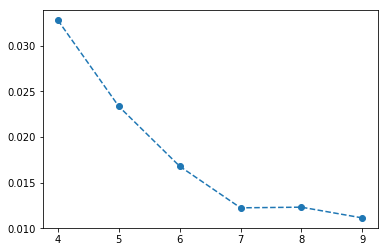

In [15]:
plt.plot(x, err, linestyle="--", marker='o')
plt.show()